# Background and Motivation

Mental health is a fundamental aspect of overall well-being, affecting how individuals think, feel, and act. With the increasing prevalence of mental health disorders such as depression, anxiety, and stress, there is a growing need for innovative solutions to monitor and address these issues proactively. Traditional methods of mental health assessment often rely on self-reported surveys and clinical evaluations, which can be time-consuming and may not capture real-time fluctuations in an individual's emotional state.

# Objective

This project aims to harness the power of sentiment analysis, a subset of natural language processing (NLP), to monitor mental health through textual data. Sentiment analysis involves the use of algorithms and machine learning techniques to identify and extract subjective information from text, categorizing it as positive, negative, or neutral. By applying sentiment analysis to text data from various sources, we can gain valuable insights into the emotional and mental states of individuals.

In today's fast-paced world, mental health has emerged as a critical area of concern, impacting millions globally. The advent of digital communication, particularly through social media and online forums, has provided a unique window into the collective psyche of individuals, offering valuable insights into their emotional and mental states. Our project leverages sentiment analysis, a powerful tool in the field of natural language processing (NLP), to monitor and assess mental health trends through textual data.

The primary objective of this project is to develop a robust model that can accurately classify text based on sentiment, helping to identify early signs of mental health issues such as anxiety, depression, and stress. By analyzing data from various sources, including social media posts, forums, and mental health support groups, our model aims to provide real-time insights into the emotional well-being of individuals.

Through this project, we aim to demonstrate how sentiment analysis can be an effective tool in mental health monitoring, offering a proactive approach to mental health care. By identifying negative sentiment patterns early, we can potentially facilitate timely interventions and support, ultimately contributing to better mental health outcomes.

# import libraries 

In [1]:
import pandas as pd
import numpy as np
import string
import spacy
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import seaborn as sns
%matplotlib inline
import re
from sklearn.naive_bayes import BernoulliNB
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import joblib
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb
from multiprocessing import Pool, cpu_count
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras import Model


2025-11-12 16:54:32.476863: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762966472.665470      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762966472.717154      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
df=pd.read_csv('/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv',index_col=0)
df.head(10)

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety
5,"every break, you must be nervous, like somethi...",Anxiety
6,"I feel scared, anxious, what can I do? And may...",Anxiety
7,Have you ever felt nervous but didn't know why?,Anxiety
8,"I haven't slept well for 2 days, it's like I'm...",Anxiety
9,"I'm really worried, I want to cry.",Anxiety


# Handling Missing Value

In [3]:
print(df.isnull().sum())

statement    362
status         0
dtype: int64


In [4]:
df = df.dropna()
print(df.isnull().sum())

statement    0
status       0
dtype: int64


In [5]:
df['status'].nunique()

7

# Let us understand the data

In [6]:
sentiment_counts=df['status'].value_counts()
print(sentiment_counts)

status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64


<Axes: title={'center': 'Distribution of Sentiments'}, xlabel='status'>

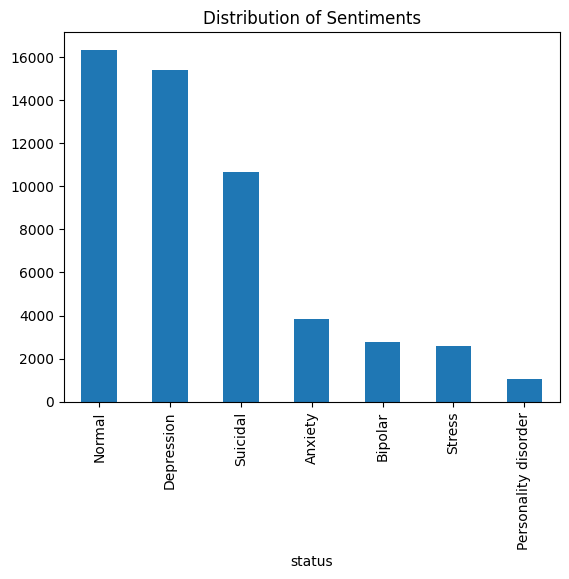

In [7]:
sentiment_counts.plot(kind='bar', title='Distribution of Sentiments')

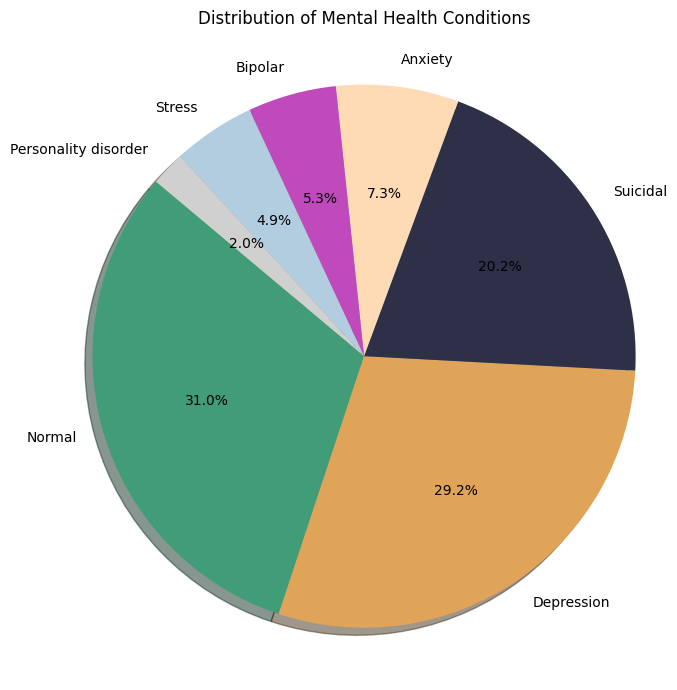

In [8]:
# Count the occurrences of each category
status_counts = df['status'].value_counts()

# Define colors for each category (7 colors)
colors = ['#419D78', '#E0A458', '#2D3047', '#FFDBB5', '#C04ABC', '#B3CDE0', '#D0D0D0']

# Create the pie chart
plt.figure(figsize=(7, 7))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', 
        startangle=140, colors=colors, shadow=True)

plt.title('Distribution of Mental Health Conditions')
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.

# Display the chart
plt.tight_layout()
plt.show()

In [9]:
sentiment_classes =df['status'].unique()
sentiment_classes

array(['Anxiety', 'Normal', 'Depression', 'Suicidal', 'Stress', 'Bipolar',
       'Personality disorder'], dtype=object)

In [10]:
df.shape

(52681, 2)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52681 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     52681 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [12]:
df.describe()

,statement,status
count,52681,52681
unique,51073,7
top,what do you mean?,Normal
freq,22,16343


# Looking at raw texts

In [13]:
# Group by status and get a random statement from each group
random_statements = df.groupby('status')['statement'].apply(lambda x: x.sample(n=1).iloc[0])

# Print the results
for status, statement in random_statements.items():
    print(f"Status: {status}")
    print(f"Statement: {statement}\n")

Status: Anxiety
Statement: I choked on a grape and now I'm worried that it got into my lungs, does this sound possible? As stupid as this sounds, my anxiety is telling me that since I was eating a grape and laughed and coughed a bit, I inhaled the juice and my lungs are going to react. Should I worry?  

The long version is: I laughed while eating a grape and it caused me to cough, it was more coughing than I'm used to and it burned a bit, so I was worried that I didn't cough it out well enough. I'm feeling a little tired now (6hrs later) and short of breath and my mucus is that sickly yellow. I felt immediate pain an hour after it happened but I don't feel it anymore, but most of these might be health anxiety. I haven't coughed since it happened, which should tell me that nothing is wrong but I'm worried nonetheless. I spend most of my time worrying about this sort of thing and I realise it's bordering impossible to have it happen but I can't stop worrying. 

Status: Bipolar
Statement

In [14]:
import nltk

# Calculate the number of characters and sentences
df['num_of_characters'] = df['statement'].str.len()
df['num_of_sentences'] = df['statement'].apply(lambda x: len(nltk.sent_tokenize(x)))

# Generate descriptive statistics
description = df[['num_of_characters', 'num_of_sentences']].describe()

# Display the descriptive statistics
print(description)

       num_of_characters  num_of_sentences
count       52681.000000      52681.000000
mean          578.713863          6.280215
std           846.269078         10.688388
min             2.000000          1.000000
25%            80.000000          1.000000
50%           317.000000          3.000000
75%           752.000000          8.000000
max         32759.000000       1260.000000


We have several lengthy messages, most of which express suicidal thoughts or signs of depression:

In [15]:
df[df['num_of_characters'] > 10000]

,statement,status,num_of_characters,num_of_sentences
7851,So introduction I guess.. my name is Michael a...,Depression,10679,136
9416,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,Suicidal,25302,1
9504,"Hello everyone,I rarely post on Reddit but.......",Depression,11163,139
10834,I have only 1 person I can somewhat open to bu...,Suicidal,27390,237
11537,"The title is not meant to discourage others, b...",Depression,12304,155
11581,I no longer know what else to do but write thi...,Depression,13530,140
11636,And has life gotten better?&amp;#x200B;No. Eve...,Depression,12819,96
11831,Sorry this is long but I doubt anyone will eve...,Depression,11122,155
13293,I cannot TAKE IT ANYMORE. I cannot TAKE IT ANY...,Suicidal,32759,1260
18215,I am someone living in Turkey. My age is proba...,Suicidal,10219,180


count    52681.000000
mean       578.713863
std        846.269078
min          2.000000
25%         80.000000
50%        317.000000
75%        752.000000
max      32759.000000
Name: statement_length, dtype: float64


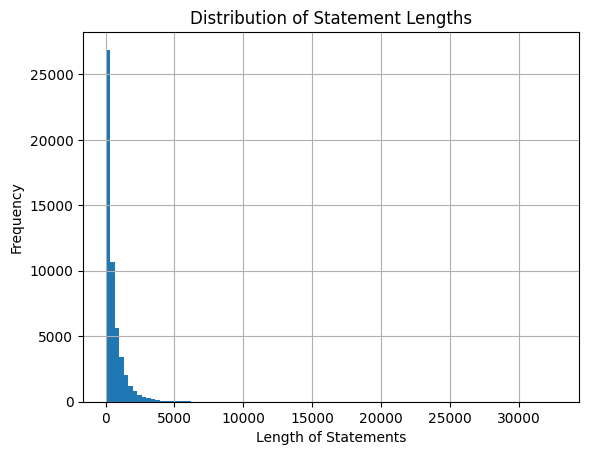

In [16]:
# Calculate the length of each statement
df['statement_length'] = df['statement'].apply(len)

# Display basic statistics of statement lengths
print(df['statement_length'].describe())

# Plot the distribution of statement lengths
df['statement_length'].hist(bins=100)
plt.title('Distribution of Statement Lengths')
plt.xlabel('Length of Statements')
plt.ylabel('Frequency')
plt.show()

# Excluding the outliers

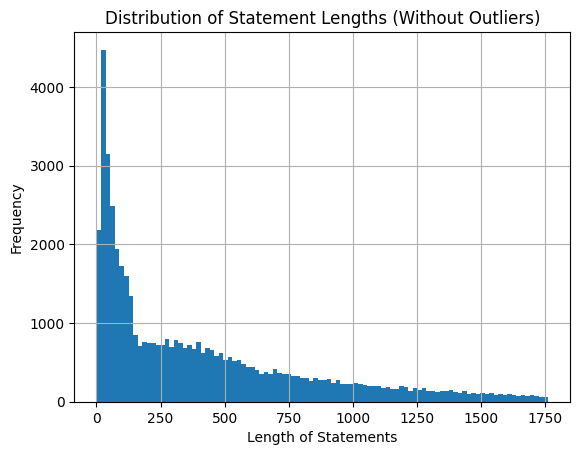

In [17]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df['statement_length'].quantile(0.25)
Q3 = df['statement_length'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bound for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
filtered_df = df[(df['statement_length'] >= lower_bound) & (df['statement_length'] <= upper_bound)]
# Plot the distribution of statement lengths without outliers
filtered_df['statement_length'].hist(bins=100)
plt.title('Distribution of Statement Lengths (Without Outliers)')
plt.xlabel('Length of Statements')
plt.ylabel('Frequency')
plt.show()

# Text Preprocessing

## Lowercasing
Convert all statements to lowercase to ensure uniformity.

In [18]:
df.rename(columns={'statement': 'original_statement'}, inplace=True)  

df['statement']=df['original_statement'].str.lower()
df.head()

,original_statement,status,num_of_characters,num_of_sentences,statement_length,statement
0,oh my gosh,Anxiety,10,1,10,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,64,"trouble sleeping, confused mind, restless hear..."
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,78,"all wrong, back off dear, forward doubt. stay ..."
3,I've shifted my focus to something else but I'...,Anxiety,61,1,61,i've shifted my focus to something else but i'...
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,72,"i'm restless and restless, it's been a month n..."


## Removing URLs, handles, punctuation and special characters

To remove specific patterns such as URLs or other unwanted text (like [View Poll](https://www.reddit.com/poll/...)) from a column in a pandas DataFrame, we can use regular expressions with the re module or pandas built-in string methods.

In [19]:
def remove_patterns(text):
    # Remove URLs
    text = re.sub(r'http[s]?://\S+', '', text)
    # Remove markdown-style links
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)
    # Remove handles (that start with '@')
    text = re.sub(r'@\w+', '', text)
    # Remove punctuation and other special characters
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

# Apply the function to the 'statement' column
df['statement'] = df['statement'].apply(remove_patterns)
df.head()

,original_statement,status,num_of_characters,num_of_sentences,statement_length,statement
0,oh my gosh,Anxiety,10,1,10,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,64,trouble sleeping confused mind restless heart ...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,78,all wrong back off dear forward doubt stay in ...
3,I've shifted my focus to something else but I'...,Anxiety,61,1,61,ive shifted my focus to something else but im ...
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,72,im restless and restless its been a month now ...


# Tokenization

In [20]:
# Apply word_tokenize to each element in the 'statement' column
df['tokens'] = df['statement'].apply(word_tokenize)
df.head()

,original_statement,status,num_of_characters,num_of_sentences,statement_length,statement,tokens
0,oh my gosh,Anxiety,10,1,10,oh my gosh,"[oh, my, gosh]"
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,64,trouble sleeping confused mind restless heart ...,"[trouble, sleeping, confused, mind, restless, ..."
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,78,all wrong back off dear forward doubt stay in ...,"[all, wrong, back, off, dear, forward, doubt, ..."
3,I've shifted my focus to something else but I'...,Anxiety,61,1,61,ive shifted my focus to something else but im ...,"[ive, shifted, my, focus, to, something, else,..."
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,72,im restless and restless its been a month now ...,"[im, restless, and, restless, its, been, a, mo..."


# Stemming

Reduce words to their base or root form. However, in some cases, the stemming process produces words that are not correct spellings of the root word. For example, happi and sunni. That's because it chooses the most common stem for related words. For example, we can look at the set of words that comprises the different forms of happy:

- happy
- happiness
- happier
  
We can see that the prefix happi is more commonly used. We cannot choose happ because it is the stem of unrelated words like happen.

In [21]:
from nltk.stem import PorterStemmer
# Initialize the stemmer
stemmer = PorterStemmer()

# Function to stem tokens and convert them to strings
def stem_tokens(tokens):
    return ' '.join(stemmer.stem(str(token)) for token in tokens)

# Apply the function to the 'tokens' column
df['tokens_stemmed'] = df['tokens'].apply(stem_tokens)

df.head()

,original_statement,status,num_of_characters,num_of_sentences,statement_length,statement,tokens,tokens_stemmed
0,oh my gosh,Anxiety,10,1,10,oh my gosh,"[oh, my, gosh]",oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,64,trouble sleeping confused mind restless heart ...,"[trouble, sleeping, confused, mind, restless, ...",troubl sleep confus mind restless heart all ou...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,78,all wrong back off dear forward doubt stay in ...,"[all, wrong, back, off, dear, forward, doubt, ...",all wrong back off dear forward doubt stay in ...
3,I've shifted my focus to something else but I'...,Anxiety,61,1,61,ive shifted my focus to something else but im ...,"[ive, shifted, my, focus, to, something, else,...",ive shift my focu to someth els but im still w...
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,72,im restless and restless its been a month now ...,"[im, restless, and, restless, its, been, a, mo...",im restless and restless it been a month now b...


# Stop Words

While stop words are typically removed to reduce noise, in sentiment analysis for mental health, many stop words are actually crucial for understanding context and sentiment. Words like negations and those related to emotions (e.g., 'how', 'why', 'because') provide important insights. Removing these can decrease the accuracy of the analysis.

# Word Clouds

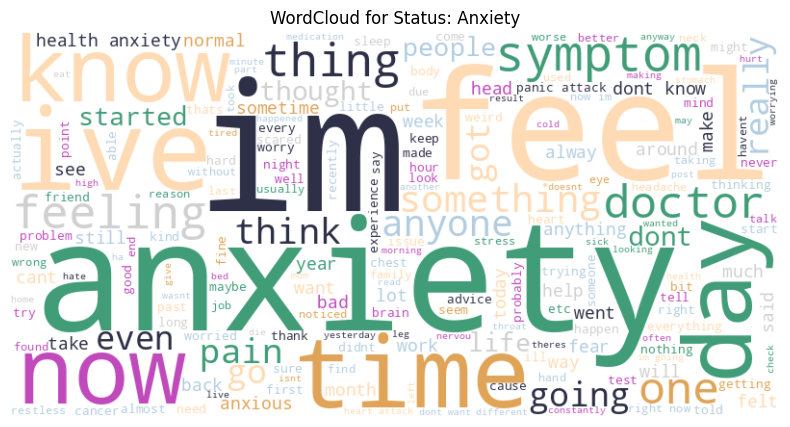

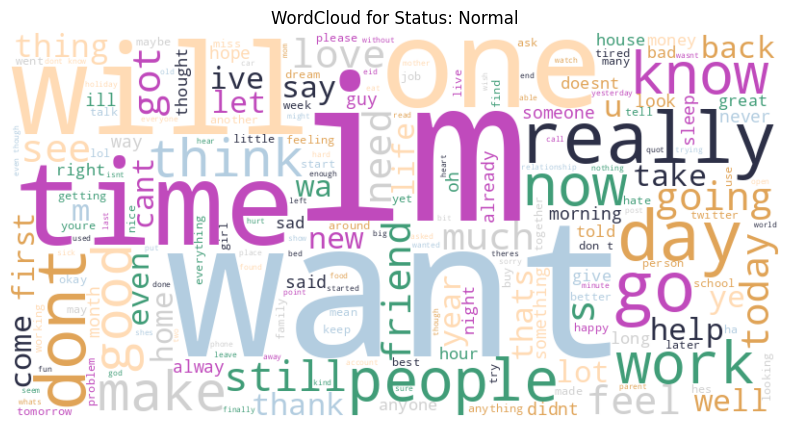

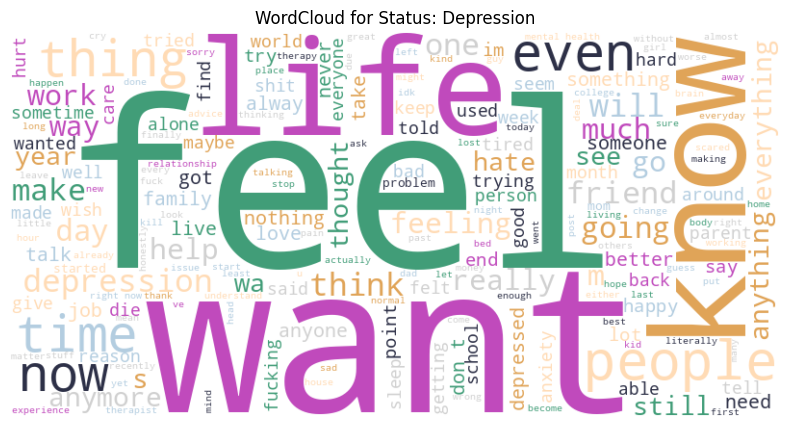

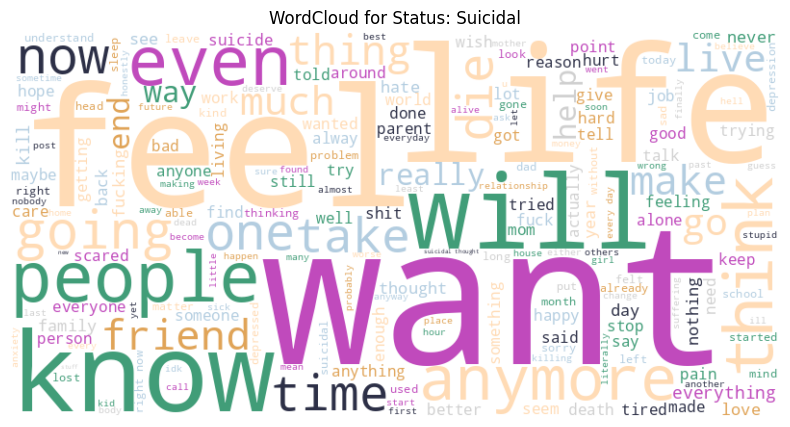

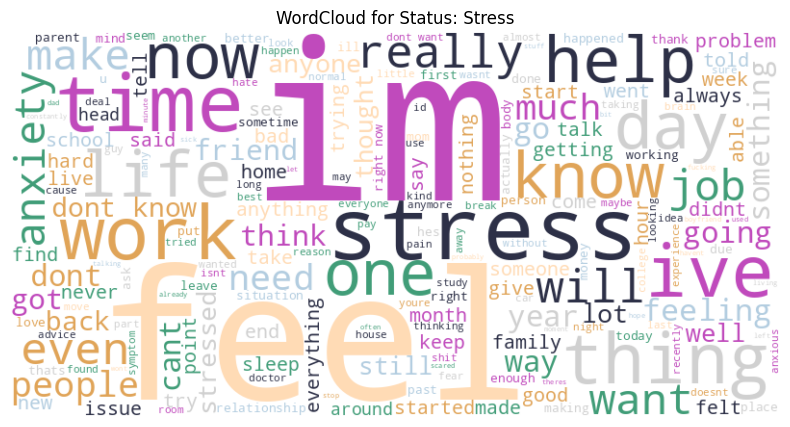

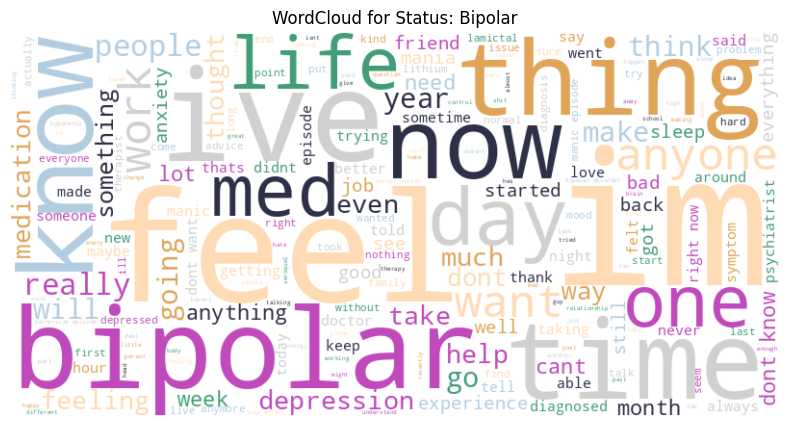

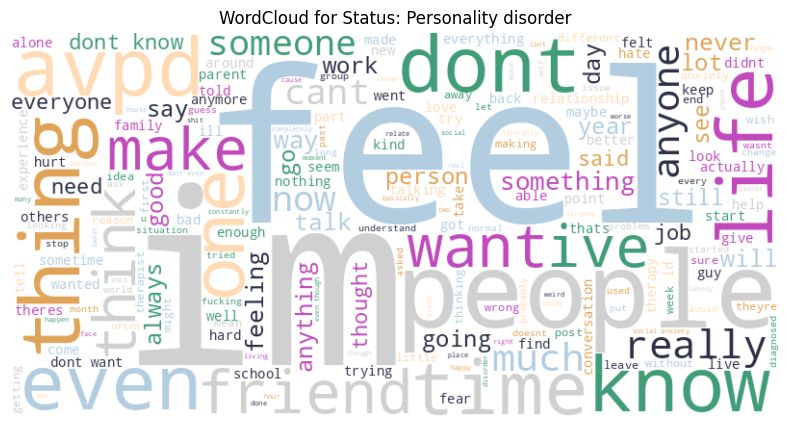

In [22]:
from wordcloud import WordCloud
import random
# Get unique categories in 'status'
statuses = df['status'].unique()

# Define a color function
def color_func(word, font_size, position, orientation, random_state=101, **kwargs):
    return random.choice(colors)

# Generate and plot the WordCloud for each category
for status in statuses:
    # Filter the tokens data for the current status
    tokens_data = ' '.join(df[df['status'] == status]['tokens'].dropna().apply(lambda x: ' '.join(x)).tolist())

    # Generate the WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate(tokens_data)
    
    # Plot the WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off axis
    plt.title(f'WordCloud for Status: {status}')
    plt.show()

There is a significant overlap in the language used for discussing depression and suicidal thoughts in our data. Many terms and phrases are used interchangeably or similarly for both conditions, which may complicate the distinction between them.

In [23]:
df

,original_statement,status,num_of_characters,num_of_sentences,statement_length,statement,tokens,tokens_stemmed
0,oh my gosh,Anxiety,10,1,10,oh my gosh,"[oh, my, gosh]",oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,64,trouble sleeping confused mind restless heart ...,"[trouble, sleeping, confused, mind, restless, ...",troubl sleep confus mind restless heart all ou...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,78,all wrong back off dear forward doubt stay in ...,"[all, wrong, back, off, dear, forward, doubt, ...",all wrong back off dear forward doubt stay in ...
3,I've shifted my focus to something else but I'...,Anxiety,61,1,61,ive shifted my focus to something else but im ...,"[ive, shifted, my, focus, to, something, else,...",ive shift my focu to someth els but im still w...
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,72,im restless and restless its been a month now ...,"[im, restless, and, restless, its, been, a, mo...",im restless and restless it been a month now b...
...,...,...,...,...,...,...,...,...
53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety,1766,16,1766,nobody takes me seriously ive 24m dealt with d...,"[nobody, takes, me, seriously, ive, 24m, dealt...",nobodi take me serious ive 24m dealt with depr...
53039,"selfishness ""I don't feel very good, it's lik...",Anxiety,1012,12,1012,selfishness i dont feel very good its like i ...,"[selfishness, i, dont, feel, very, good, its, ...",selfish i dont feel veri good it like i dont b...
53040,Is there any way to sleep better? I can't slee...,Anxiety,85,2,85,is there any way to sleep better i cant sleep ...,"[is, there, any, way, to, sleep, better, i, ca...",is there ani way to sleep better i cant sleep ...
53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety,401,6,401,public speaking tips hi all i have to give a p...,"[public, speaking, tips, hi, all, i, have, to,...",public speak tip hi all i have to give a prese...


# Separate features and labels

In [24]:
def tweet_to_words(tweet):
    ''' Convert tweet text into a sequence of words '''
    
    # convert to lowercase
    text = tweet.lower()
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # tokenize
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # apply stemming
    words = [PorterStemmer().stem(w) for w in words]
    # return list
    return words

print("\nOriginal tweet ->", df['original_statement'][0])
print("\nProcessed tweet ->", tweet_to_words(df['original_statement'][0]))


Original tweet -> oh my gosh

Processed tweet -> ['oh', 'gosh']


In [25]:
# Apply data processing to each tweet
X = list(map(tweet_to_words, df['original_statement']))
X[0]

['oh', 'gosh']

In [26]:
from sklearn.preprocessing import LabelEncoder

# Encode target labels
le = LabelEncoder()
Y = le.fit_transform(df['status'])
Y[0]

0

In [27]:
print(X[0])
print(Y[0])

['oh', 'gosh']
0


In [28]:
y = pd.get_dummies(df['status'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

# CountVectorizer 

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.feature_extraction.text import TfidfVectorizer

vocabulary_size = 5000

# Tweets have already been preprocessed hence dummy function will be passed in 
# to preprocessor & tokenizer step
count_vector = CountVectorizer(max_features=vocabulary_size,
#                               ngram_range=(1,2),    # unigram and bigram
                                preprocessor=lambda x: x,
                               tokenizer=lambda x: x) 
#tfidf_vector = TfidfVectorizer(lowercase=True, stop_words='english')

# Fit the training data
X_train = count_vector.fit_transform(X_train).toarray()

# Transform testing data
X_test = count_vector.transform(X_test).toarray()

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [30]:
print(count_vector.get_feature_names_out()[0:200])

['0' '00' '000' '00b' '02' '03' '05' '07' '08' '0mg' '1' '10' '100' '1000'
 '100mg' '10k' '10mg' '10pm' '10th' '10x' '11' '110' '11th' '12' '120'
 '12th' '13' '130' '14' '140' '15' '150' '150mg' '15mg' '15th' '16' '17'
 '18' '180' '18f' '18th' '19' '19f' '19m' '1am' '1st' '2' '20' '200'
 '2000' '200mg' '2011' '2012' '2013' '2014' '2015' '2016' '2017' '2018'
 '2019' '2020' '2021' '2022' '2023' '20f' '20mg' '21' '21f' '21st' '22'
 '22f' '23' '23f' '24' '24m' '25' '250' '25mg' '26' '27' '28' '29' '2am'
 '2nd' '2x' '3' '30' '300' '300mg' '30am' '30mg' '30th' '31' '31st' '32'
 '33' '34' '35' '36' '37' '38' '39' '3am' '3rd' '3x' '4' '40' '400' '40mg'
 '45' '48' '4am' '4th' '5' '50' '500' '500mg' '50mg' '55' '5mg' '5th' '6'
 '60' '600' '65' '6am' '6th' '7' '70' '71' '72' '75' '7th' '8' '80' '800'
 '85' '8th' '9' '90' '900' '911' '95' '99' '9am' '9th' 'aa' 'ab' 'abandon'
 'abdomen' 'abdomin' 'abil' 'abilifi' 'abl' 'abnorm' 'abort' 'abroad'
 'abruptli' 'abscess' 'absenc' 'absent' 'absolut' 'abs

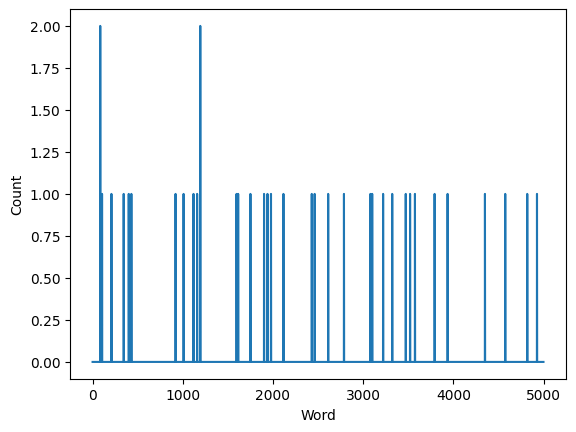

In [31]:
# Plot the BoW feature vector
plt.plot(X_train[2,:])
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()

# Tokenizing & Padding

In [32]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 5000
max_len=50

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', df['original_statement'][0])
X, tokenizer = tokenize_pad_sequences(df['original_statement'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 oh my gosh
After Tokenization & Padding 
 [ 604    5 4883    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [33]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [34]:
y = pd.get_dummies(df['status'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, y_test.shape)

Train Set -> (31608, 50) (31608, 7)
Validation Set -> (10536, 50) (10536, 7)
Test Set -> (10537, 50) (10537, 7)


# ML Algorithm

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

classifiers = {
    'Bernoulli Naive Bayes': BernoulliNB(alpha=0.1, binarize=0.0),
    'Decision Tree': DecisionTreeClassifier(max_depth=9, min_samples_split=5, random_state=101), 
    'Logistic Regression': LogisticRegression(solver='liblinear', penalty='l1', C=10, random_state=101),
    'XGB': XGBClassifier(learning_rate=0.2, max_depth=7, n_estimators=500, random_state=101, tree_method='gpu_hist')
}

In [36]:
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# # Initialize a list to store accuracy scores for each classifier
# accuracy_scores = []

# # Iterate over each classifier and its name in the classifiers dictionary
# for name, clf in classifiers.items():
#     clf.fit(X_train, y_train)
#     y_pred = clf.predict(X_test)
#     accuracy = accuracy_score(y_test, y_pred)
    
#     print("\n")
#     print("For", name)
#     print("Accuracy:", accuracy)
    
#     # Compute the confusion matrix for the predictions
#     # 'lbl_enc.classes_' provides the class labels for the confusion matrix and classification report
#     labels = lbl_enc.classes_
#     conf_matrix = confusion_matrix(y_test, y_pred)
#     print(classification_report(y_test, y_pred, target_names=labels))
    
#     # Plot the confusion matrix using a heatmap
#     # Annotate each cell with the numeric value of the confusion matrix
#     sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
#     plt.xlabel('Predicted')  # Label for x-axis
#     plt.ylabel('Actual')     # Label for y-axis
#     plt.title(f'Confusion Matrix for {name}')  # Title for the heatmap
#     plt.show()  # Display the heatmap
    
#     # Append the accuracy score to the list
#     accuracy_scores.append(accuracy)

In [37]:
# # Create a DataFrame to store classifier names and their corresponding accuracy scores
# accuracies_df = pd.DataFrame({'Classifier': classifiers.keys(), 'Accuracy': accuracy_scores}).sort_values('Accuracy', ascending=False)

# plt.figure(figsize=(12, 8))
# palette = dict(zip(accuracies_df['Classifier'], colors[:4]))

# # Create a bar plot to visualize the accuracy of each classifier
# sns.barplot(x='Classifier', y='Accuracy', data=accuracies_df, palette=palette)

# plt.title("Classifier Accuracy Comparison")
# plt.ylim(0, 1)

# plt.tight_layout()
# plt.show()

# Bidirectional LSTM Using NN

In [38]:
import keras.backend as K

def f1_score(precision, recall):
    ''' Function to calculate f1 score '''
    
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [39]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses

vocab_size = 5000
embedding_size = 32
epochs=50
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
# Build model
model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(7, activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=sgd, 
               metrics=['accuracy', Precision(), Recall()])

print(model.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
I0000 00:00:1762967093.951069      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [40]:
# Compile model
model.compile(loss='categorical_crossentropy', optimizer=sgd, 
               metrics=['accuracy', Precision(), Recall()])

# Train model

batch_size = 64
history = model.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/50


I0000 00:00:1762967097.475128     113 cuda_dnn.cc:529] Loaded cuDNN version 90300


494/494 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.5067 - loss: 1.3434 - precision_1: 0.7273 - recall_1: 0.2489 - val_accuracy: 0.5617 - val_loss: 1.0502 - val_precision_1: 0.6830 - val_recall_1: 0.4376
Epoch 2/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5703 - loss: 1.0337 - precision_1: 0.6821 - recall_1: 0.4663 - val_accuracy: 0.5937 - val_loss: 0.9504 - val_precision_1: 0.7129 - val_recall_1: 0.4723
Epoch 3/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5987 - loss: 0.9400 - precision_1: 0.7006 - recall_1: 0.5097 - val_accuracy: 0.6219 - val_loss: 0.8850 - val_precision_1: 0.7168 - val_recall_1: 0.5274
Epoch 4/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6251 - loss: 0.8743 - precision_1: 0.7169 - recall_1: 0.5401 - val_accuracy: 0.6428 - val_loss: 0.8624 - val_precision_1: 0.7458 - val_recall_1: 0.5465
Epoch 5/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6562 - loss: 0.8201 - precision_1: 0.7480 - recall_1: 0.5772 - val_accur

In [41]:
# Evaluate model on the test set
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))


Accuracy  : 0.7123
Precision : 0.7184
Recall    : 0.7086
F1 Score  : 0.7134


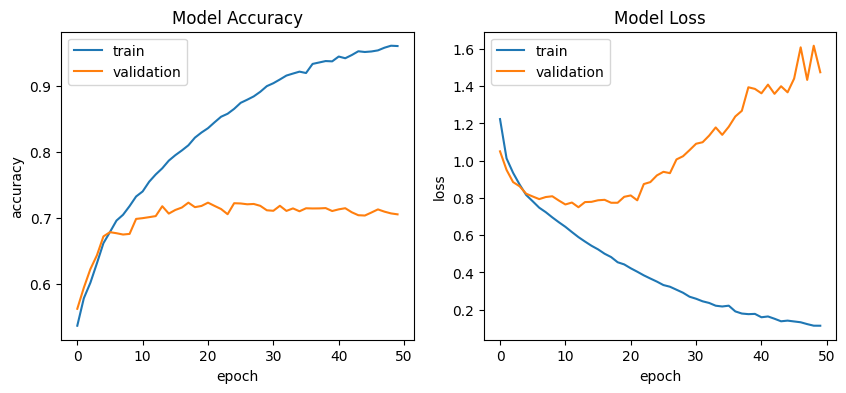

In [42]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(history)

In [43]:
sentiment_classes =df['status'].unique()

330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


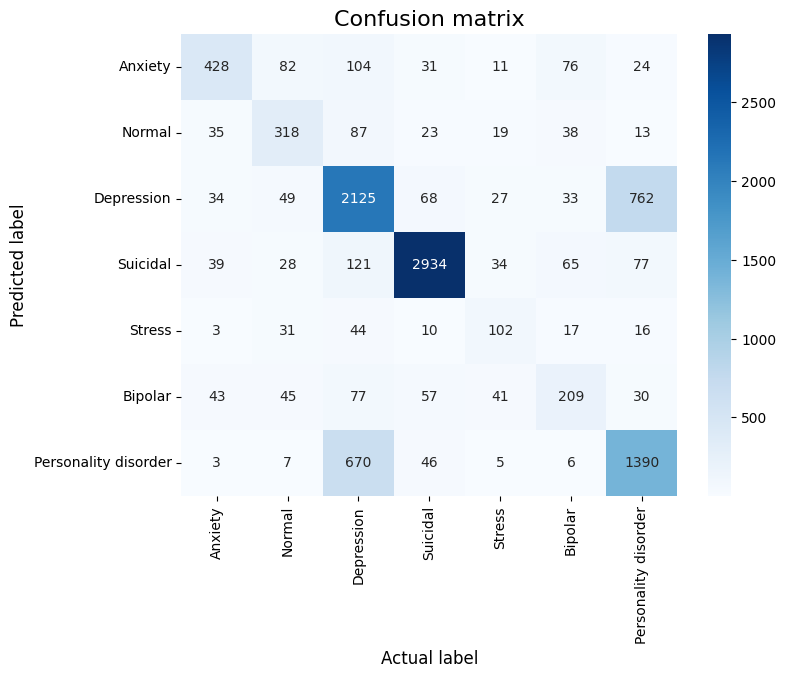

In [44]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model, X_test, y_test)

In [45]:
# Save the model architecture & the weights
model.save('best_model.h5')
print('Best model saved')

Best model saved


In [46]:
from keras.models import load_model

# Load model
model = load_model('best_model.h5')

def predict_class(text):
    '''Function to predict sentiment class of the passed text'''

    max_len=50
    
    # Transforms text to a sequence of integers using a tokenizer object
    xt = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    xt = pad_sequences(xt, padding='post', maxlen=max_len)
    # Do the prediction using the loaded model
    yt = model.predict(xt).argmax(axis=1)
    # Print the predicted sentiment
    print('The predicted sentiment is', sentiment_classes[yt[0]])

In [47]:
predict_class(['"I hate when I have to call and wake people up'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
The predicted sentiment is Suicidal


In [48]:
predict_class(['He is a best minister india ever had seen'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
The predicted sentiment is Suicidal


# Another Way to Pre-Process

In [49]:
# Load Data 
df = pd.read_csv('/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv')
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [50]:
# Drop column 'B'
df = df.drop('Unnamed: 0', axis=1)

df.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [51]:
# Rename specific columns
df = df.rename(columns={'statement': 'Text', 'status': 'Label'})
df.head()

,Text,Label
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [52]:
from sklearn.preprocessing import LabelEncoder

# Encode target labels
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])
df.head()

,Text,Label
0,oh my gosh,0
1,"trouble sleeping, confused mind, restless hear...",0
2,"All wrong, back off dear, forward doubt. Stay ...",0
3,I've shifted my focus to something else but I'...,0
4,"I'm restless and restless, it's been a month n...",0


In [53]:
 #Import Basis Needed Libaries 
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# # Download NLTK resources (uncomment the following line if not already downloaded)?
# nltk.download('punkt')
# nltk.download('stopwords')

In [54]:
# Step 1: Remove URLs
df['Text'] = df['Text'].str.replace(r'http\S+', '', regex=True)

# Display the first few rows of the DataFrame to verify the changes
print(df.head())

                                                Text  Label
0                                         oh my gosh      0
1  trouble sleeping, confused mind, restless hear...      0
2  All wrong, back off dear, forward doubt. Stay ...      0
3  I've shifted my focus to something else but I'...      0
4  I'm restless and restless, it's been a month n...      0


In [55]:
# Step 2: Remove special characters and punctuation
df['Text'] = df['Text'].str.replace(r'[^\w\s]', '', regex=True)

# Display the first few rows of the DataFrame to verify the changes
print(df.head())

                                                Text  Label
0                                         oh my gosh      0
1  trouble sleeping confused mind restless heart ...      0
2  All wrong back off dear forward doubt Stay in ...      0
3  Ive shifted my focus to something else but Im ...      0
4  Im restless and restless its been a month now ...      0


In [56]:
# Step 3: Remove extra whitespaces
df['Text'] = df['Text'].str.replace(r'\s+', ' ', regex=True)

# Display the first few rows of the DataFrame to verify the changes
print(df.head())

                                                Text  Label
0                                         oh my gosh      0
1  trouble sleeping confused mind restless heart ...      0
2  All wrong back off dear forward doubt Stay in ...      0
3  Ive shifted my focus to something else but Im ...      0
4  Im restless and restless its been a month now ...      0


In [57]:
# Step : 4 Remove numeric values
df['Text'] = df['Text'].str.replace(r'\d+', '', regex=True)

# Head
df.head()

,Text,Label
0,oh my gosh,0
1,trouble sleeping confused mind restless heart ...,0
2,All wrong back off dear forward doubt Stay in ...,0
3,Ive shifted my focus to something else but Im ...,0
4,Im restless and restless its been a month now ...,0


In [58]:
# Step 6: Lowercasing
df['Text'] = df['Text'].str.lower()

# Display the first few rows of the DataFrame to verify the changes
print(df.head())

                                                Text  Label
0                                         oh my gosh      0
1  trouble sleeping confused mind restless heart ...      0
2  all wrong back off dear forward doubt stay in ...      0
3  ive shifted my focus to something else but im ...      0
4  im restless and restless its been a month now ...      0


In [59]:
# Ensure stopwords are downloaded
import nltk
nltk.download('stopwords')

stop = stopwords.words('english')

# Convert to string before splitting, and handle NaN safely
df["Text"] = df["Text"].astype(str).apply(
    lambda x: ' '.join([word for word in x.split() if word.lower() not in stop])
)

# Verify
df.head()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Text,Label
0,oh gosh,0
1,trouble sleeping confused mind restless heart ...,0
2,wrong back dear forward doubt stay restless re...,0
3,ive shifted focus something else im still worried,0
4,im restless restless month boy mean,0


In [60]:
# Step : 9 Remove non-alphanumeric characters from the 'Text' column
df['Text'] = df['Text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

# Display the first few rows of the DataFrame to verify the changes
df.head()

,Text,Label
0,oh gosh,0
1,trouble sleeping confused mind restless heart ...,0
2,wrong back dear forward doubt stay restless re...,0
3,ive shifted focus something else im still worried,0
4,im restless restless month boy mean,0


In [61]:
X = df['Text']
y = df['Label']

# Train Test Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the training and testing sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (42434,)
X_test shape: (10609,)
y_train shape: (42434,)
y_test shape: (10609,)


In [62]:
# Tokenize the text data
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [63]:
# Max Len in X_train_sequences
maxlen = max(len(tokens) for tokens in X_train_sequences)
print("Maximum sequence length (maxlen):", maxlen)

Maximum sequence length (maxlen): 3780


In [64]:
# Perform padding on X_train and X_test sequences
X_train_padded = pad_sequences(X_train_sequences, maxlen=maxlen, padding='post',)
X_test_padded = pad_sequences(X_test_sequences, maxlen=maxlen, padding='post')

# Print the padded sequences for X_train and X_test
print("X_train_padded:")
print(X_train_padded)
print("\nX_test_padded:")
print(X_test_padded)

X_train_padded:
[[   32   815   729 ...     0     0     0]
 [ 8633    90   211 ...     0     0     0]
 [  821    99  1463 ...     0     0     0]
 ...
 [ 4522  1422  1005 ...     0     0     0]
 [ 2092 14119     0 ...     0     0     0]
 [ 1967   250   318 ...     0     0     0]]

X_test_padded:
[[ 1022   352     2 ...     0     0     0]
 [18914  2841 21409 ...     0     0     0]
 [  808  1579   421 ...     0     0     0]
 ...
 [   37   306    52 ...     0     0     0]
 [   58    42     5 ...     0     0     0]
 [    4    64  7871 ...     0     0     0]]


In [65]:
# Embedding Input Size / Vocabulary Size 
input_Size = np.max(X_train_padded) + 1
input_Size

50000

In [66]:
from tensorflow.keras.layers import *

# Define the model
model = Sequential()

# Add embedding layer
model.add(Embedding(input_dim=input_Size, output_dim=50, input_length=maxlen))

# Dropout
model.add(Dropout(0.5))

# Add Bidirectional LSTM layer
model.add(Bidirectional(GRU(120, return_sequences=True)))
model.add(Bidirectional(GRU(64, return_sequences=True)))

#Batch Normalization
model.add(BatchNormalization())

# Add Bidirectional GRU layer
model.add(Bidirectional(GRU(64)))

# Add output layer
model.add(Dense(7, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [67]:
# Model Train 
history = model.fit(X_train_padded, y_train, epochs=5, 
                    batch_size=64, validation_data=(X_test_padded, y_test))

Epoch 1/5
664/664 ━━━━━━━━━━━━━━━━━━━━ 777s 1s/step - accuracy: 0.6011 - loss: 1.0484 - val_accuracy: 0.7522 - val_loss: 0.6424
Epoch 2/5
664/664 ━━━━━━━━━━━━━━━━━━━━ 770s 1s/step - accuracy: 0.7876 - loss: 0.5532 - val_accuracy: 0.7714 - val_loss: 0.5823
Epoch 3/5
664/664 ━━━━━━━━━━━━━━━━━━━━ 769s 1s/step - accuracy: 0.8244 - loss: 0.4641 - val_accuracy: 0.7716 - val_loss: 0.5814
Epoch 4/5
664/664 ━━━━━━━━━━━━━━━━━━━━ 770s 1s/step - accuracy: 0.8543 - loss: 0.3838 - val_accuracy: 0.4011 - val_loss: 2.7531
Epoch 5/5
664/664 ━━━━━━━━━━━━━━━━━━━━ 770s 1s/step - accuracy: 0.8767 - loss: 0.3246 - val_accuracy: 0.7590 - val_loss: 0.6781


# Find Best Epoch

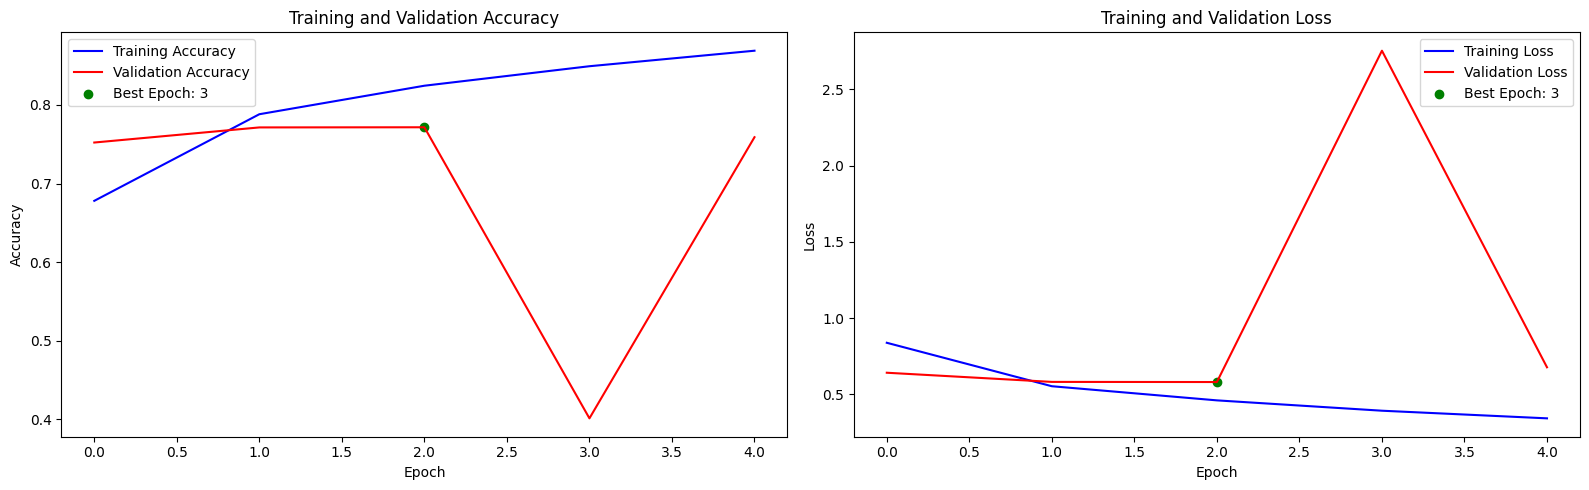

In [68]:
# Get the epoch with the highest validation accuracy
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Plot training and validation accuracy
axs[0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
axs[0].scatter(best_epoch - 1, history.history['val_accuracy'][best_epoch - 1], color='green', label=f'Best Epoch: {best_epoch}')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend()


# Plot training and validation loss
axs[1].plot(history.history['loss'], label='Training Loss', color='blue')
axs[1].plot(history.history['val_loss'], label='Validation Loss', color='red')
axs[1].scatter(best_epoch - 1, history.history['val_loss'][best_epoch - 1], color='green',label=f'Best Epoch: {best_epoch}')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

In [69]:
# Evaluate Test Data 
model.evaluate(X_test_padded, y_test)

332/332 ━━━━━━━━━━━━━━━━━━━━ 136s 409ms/step - accuracy: 0.7512 - loss: 0.6880


[0.6780611276626587, 0.7589782476425171]

In [70]:
# Predictions On Test For Confustion Matrix 
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test_padded)
y_pred = np.argmax(y_pred, axis=1)

332/332 ━━━━━━━━━━━━━━━━━━━━ 136s 408ms/step


<Axes: >

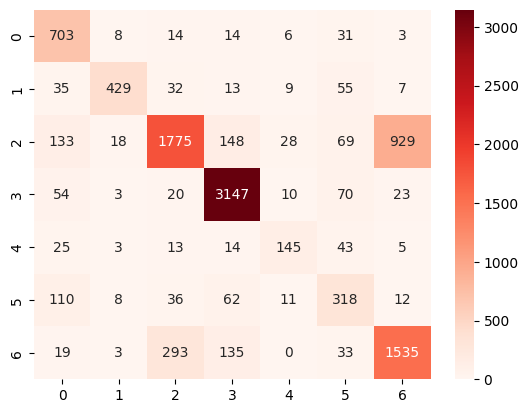

In [71]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')